In [2]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np

# --- Configuration (Use the same connection details as Task 3) ---
DB_CONFIG = {
    "host": "localhost",
    "database": "bank_reviews",
    "user": "postgres",     
    "password": "password" 
}

# Function to connect and run a SQL query, returning a Pandas DataFrame
def run_query(sql_query):
    conn = None
    try:
        conn = psycopg2.connect(**DB_CONFIG)
        df = pd.read_sql(sql_query, conn)
        return df
    except Exception as e:
        print(f"Database Query Error: {e}")
        return pd.DataFrame()
    finally:
        if conn:
            conn.close()

# -------------------------------------------------------------------
# A. Get Bank-level Metrics (Average Rating, Sentiment Scores)
# -------------------------------------------------------------------
metrics_sql = """
    SELECT 
        b.bank_name, 
        ROUND(AVG(r.rating), 2) AS avg_rating,
        AVG(CASE WHEN r.sentiment_label = 'POSITIVE' THEN r.sentiment_score END) AS avg_positive_score,
        AVG(CASE WHEN r.sentiment_label = 'NEGATIVE' THEN r.sentiment_score END) AS avg_negative_score
    FROM Reviews r
    JOIN Banks b ON b.bank_id = r.bank_id
    GROUP BY b.bank_name
    ORDER BY avg_rating DESC;
"""
df_metrics = run_query(metrics_sql)
print("Bank Metrics Data:")
print(df_metrics)

# -------------------------------------------------------------------
# B. Get Theme-level Insights (for Drivers/Pain Points)
# -------------------------------------------------------------------
themes_sql = """
    SELECT 
        b.bank_name,
        r.identified_theme,
        COUNT(r.review_id) AS review_count,
        ROUND(AVG(r.rating), 2) AS avg_rating_theme
    FROM Reviews r
    JOIN Banks b ON b.bank_id = r.bank_id
    WHERE r.identified_theme IS NOT NULL AND r.identified_theme != 'OTHER'
    GROUP BY 1, 2
    HAVING COUNT(r.review_id) > 5 -- Filter out rare themes for better signal
    ORDER BY b.bank_name, review_count DESC;
"""
df_themes = run_query(themes_sql)
print("\nTheme Insights Data:")
print(df_themes)

C:\Users\USER\AppData\Local\Temp\ipykernel_22892\842054233.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


Bank Metrics Data:
  bank_name  avg_rating  avg_positive_score  avg_negative_score
0       CBE        4.10            0.984411           -0.059917
1    Dashen        4.09            0.993293           -0.051323
2       BOA        3.31            0.980289           -0.054306

Theme Insights Data:
   bank_name           identified_theme  review_count  avg_rating_theme
0        BOA           General Feedback           382              3.70
1        BOA    Transaction Performance            58              1.95
2        BOA    Bugs/Errors & Stability            26              1.62
3        BOA             UI/UX & Design            23              2.39
4        BOA  Account Access & Security            10              2.70
5        CBE           General Feedback           422              4.28
6        CBE    Transaction Performance            34              2.79
7        CBE             UI/UX & Design            27              3.44
8        CBE  Account Access & Security             9  

C:\Users\USER\AppData\Local\Temp\ipykernel_22892\842054233.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


C:\Users\USER\AppData\Local\Temp\ipykernel_22892\619437920.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bank_name', y='avg_rating', data=df_metrics, palette='viridis')


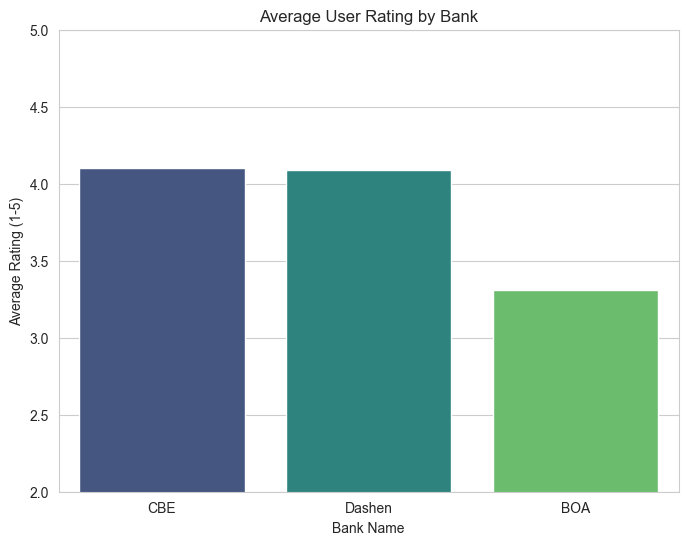

C:\Users\USER\AppData\Local\Temp\ipykernel_22892\842054233.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


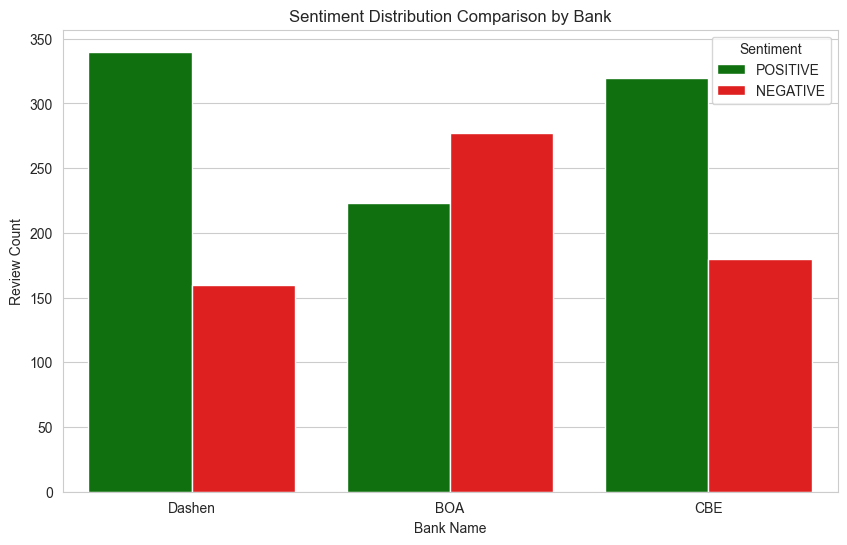

In [ ]:
# Create a new branch for visualizations
sns.set_style("whitegrid")

# Visualization 1: Average Rating Comparison (Bar Chart)
plt.figure(figsize=(8, 6))
sns.barplot(x='bank_name', y='avg_rating', data=df_metrics, palette='viridis')
plt.title('Average User Rating by Bank')
plt.ylabel('Average Rating (1-5)')
plt.xlabel('Bank Name')
plt.ylim(2.0, 5.0) # Set limits based on data range
plt.show()

# Visualization 2: Sentiment Distribution Comparison (Stacked Bar Chart)
# Requires calculating POS/NEG/NEU counts per bank first
df_sentiment_counts = run_query("""
    SELECT 
        b.bank_name, 
        r.sentiment_label,
        COUNT(r.review_id) AS count
    FROM Reviews r
    JOIN Banks b ON b.bank_id = r.bank_id
    GROUP BY 1, 2;
""")

plt.figure(figsize=(10, 6))
sns.barplot(x='bank_name', y='count', hue='sentiment_label', data=df_sentiment_counts, palette={'POSITIVE':'green', 'NEGATIVE':'red', 'NEUTRAL':'blue'})
plt.title('Sentiment Distribution Comparison by Bank')
plt.ylabel('Review Count')
plt.xlabel('Bank Name')
plt.legend(title='Sentiment')
plt.show()

# Visualization 3: Keyword Cloud of Negative Themes (High-Impact Visual)
# Requires compiling all negative review text from high-pain point themes
# need to run a query to fetch the review_text for the low-rating themes identified above,
# then feed that text into WordCloud.
# Example:
# negative_text = " ".join(df_themes[df_themes['avg_rating_theme'] < 2.5]['review_text_sample'].tolist()) 
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.title('Most Frequent Keywords in Negative Reviews')
# plt.show()

Bank Comparison and Overall Sentiment

The Bank Metrics Data provides the overall competitive landscape:

Overall Leader: CBE and Dashen are the market leaders in user satisfaction, both maintaining an average rating of ~4.10. They have the highest average positive sentiment scores.

Low performer: BOA significantly trails the competition with a low average rating of 3.31. This bank presents the greatest opportunity for improvement.

Sentiment Severity: Although Dashen has a slightly higher average rating, BOA's negative sentiment score (-0.054306) is slightly more severe than Dashen's (-0.051323), indicating that their negative experiences are particularly harsh.


 Drivers and Pain Points per Bank


BOA (Focus: Major Pain Points)

Driver: The high volume of General Feedback (382) with a 3.70 rating suggests the app's basic utility is appreciated, but no single theme stands out as a strong driver (no rating above 4.0).

Pain Points: The most critical issues are Bugs/Errors and Transaction Performance. These low scores indicate the app frequently crashes or fails at its most essential functions (moving money).



CBE (Focus: Strengths and Targeted Fixes)

Driver: The overall General Feedback rating of 4.28 is the primary driver of satisfaction.

Pain Points: Transaction Performance (2.79) and Account Access (3.00) are weaker areas that are pulling the overall rating down.

Dashen (Focus: Strengths and Critical Security/Access Issues)

Drivers: UI/UX & Design and General Feedback are extremely strong (both over 4.3). Users clearly love the app's look and feel.

Pain Points: The low scores for Bugs/Errors and Account Access indicate severe, yet potentially isolated, issues related to stability and getting into the app.